In [1]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from pytorch_lightning.utilities.seed import seed_everything
from robustbench.utils import load_model
from torch import Tensor
from torch.nn import Module
from torch.utils.data import DataLoader
from torchattacks import APGD, FGSM, PGD
from torchvision import transforms as T

In [ ]:
root = os.path.join('..')
device = torch.device('cuda:0')

In [2]:
def freeze(model: Module) -> None:
    for p in model.parameters():
        p.requires_grad = False
    model.eval()

@torch.no_grad()
def calc_acc(model: Module, imgs: Tensor, labels: Tensor) -> float:
    logits = model(imgs)
    pred_labels = logits.max(1)[1]
    corrects = pred_labels == labels
    acc = corrects.sum() / len(corrects)
    return acc.item()

dataset_root = os.path.join(os.path.sep, 'root', 'datasets')
dataset = torchvision.datasets.CIFAR10(dataset_root, False, T.ToTensor())

dataloader = DataLoader(dataset, batch_size=100, shuffle=False, pin_memory=True)
imgs, labels = next(iter(dataloader))
imgs = imgs.to(device)
labels = labels.to(device)

# This model includes normalization module
# Mean (0.4914, 0.4822, 0.4465)
# Std (0.2471, 0.2435, 0.2616)
model = load_model('Engstrom2019Robustness', threat_model='Linf')
freeze(model)
model = model.to(device)

sns.set_theme()

### Comparison with FGSM, PGD, and APGD in CIFAR-10

##### Fast Gradient Sign Method (FGSM)
- [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572)
- One-iteration

##### Projected Gradient Descent (PGD)
- [Towards Deep Learning Models Resistant to Adversarial Attacks](https://arxiv.org/abs/1706.06083)
- Multi-iteration

##### Auto-PGD (APGD)
- [Reliable evaluation of adversarial robustness with an ensemble of diverse parameter-free attacks](https://arxiv.org/abs/2003.01690)
- Multi-iteration and dynamical step

In [3]:
seed_everything(0, True)

atk_acc_dict = {}
atk_names = ('FGSM', 'PGD', 'APGD')
perturbation_constraints = (0/255, 2/255, 4/255, 6/255, 8/255)

natural_acc = calc_acc(model, imgs, labels)

for atk_name in atk_names:
    
    # If perturbation constraint is 0/255
    # attack accuracy is error rate for natural data
    atk_acc_dict[atk_name] = [1 - natural_acc]

    for perturbation_constraint in perturbation_constraints[1:]:

        if atk_name == 'FGSM':
            atk = FGSM(model, perturbation_constraint)
        elif atk_name == 'PGD':
            atk = PGD(model, perturbation_constraint, perturbation_constraint / 4, 25)
        else:
            atk = APGD(model, eps=perturbation_constraint, steps=25)

        advs = atk(imgs, labels)
        robust_acc = calc_acc(model, advs, labels)
        atk_acc_dict[atk_name].append(1 - robust_acc)


Global seed set to 0


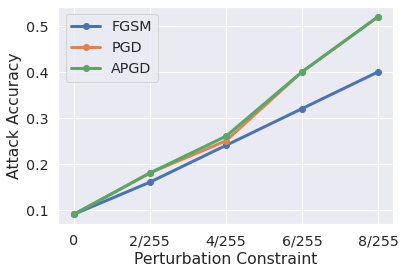

In [4]:
sns.set_context('notebook', 1.3) # type: ignore

for atk_name in atk_names:
    plt.plot(perturbation_constraints, atk_acc_dict[atk_name], label=atk_name, linewidth=3, marker='o')

plt.legend()
plt.xticks(perturbation_constraints, labels=('0', '2/255', '4/255', '6/255', '8/255'))
plt.xlabel('Perturbation Constraint')
plt.ylabel('Attack Accuracy')

path = os.path.join(root, 'graphs', 'atk_acc_by_grad_based_atks.pdf')
plt.savefig(path, bbox_inches='tight', pad_inches=0.025)

plt.show()

### Comparison with cross-entropy and DLR loss under gradient masking
Adversarial attacks based on cross-entropy sometimes fail to deceive classifiers due to gradient vanishing (gradient masking). The Difference of Logits Ratio (DLR) loss (in [Reliable evaluation of adversarial robustness with an ensemble of diverse parameter-free attacks](https://arxiv.org/abs/2003.01690)) can prevent this. Here, we intentionally craft classifiers with gradient masking to demonstrate the limitations of cross-entropy loss.

In [5]:
seed_everything(0, True)

class GradVanishedModel(Module):
    def __init__(self, model: Module) -> None:
        super().__init__()
        self.model = model

    def forward(self, x: Tensor) -> Tensor:
        logits = self.model(x)
        logits *= 9999999 # vanish gradients
        return logits

grad_vanished_model = GradVanishedModel(model)
freeze(grad_vanished_model)
grad_vanished_model = grad_vanished_model.to(device)

model_list = [model, grad_vanished_model]

atk_acc_list = []
loss_names = ('Cross-Entropy', 'Difference of Logits Ratio')

for model_tmp in model_list: # avoid duplicate variable name
    natural_err = 1 - calc_acc(model_tmp, imgs, labels)

    for loss_name in loss_names:

        if loss_name == 'Cross-Entropy':
            atk = APGD(model_tmp, eps=8/255, steps=25, loss='ce')
        else:
            atk = APGD(model_tmp, eps=8/255, steps=25, loss='dlr')

        advs = atk(imgs, labels)
        acc = calc_acc(model_tmp, advs, labels)

        # Here, we subtract the error rate for natural images 
        # from the error rate for adversarial examples.
        # This differs from the above evaluation.
        atk_acc = 1 - acc - natural_err
        atk_acc_list.append(atk_acc)


Global seed set to 0


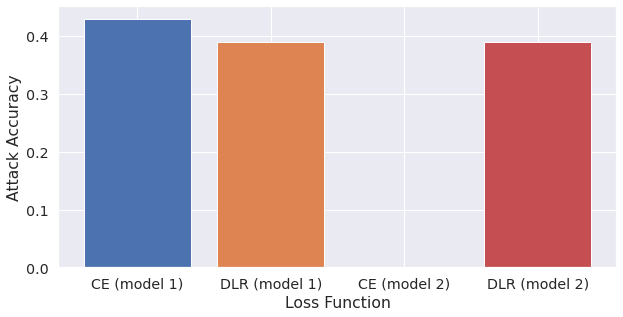

In [6]:
sns.set_context('notebook', 1.3) # type: ignore

plt.figure(figsize=(10, 4.8))

x = ('CE (model 1)', 'DLR (model 1)', 'CE (model 2)', 'DLR (model 2)')
plt.bar(x, atk_acc_list, color=sns.color_palette())

plt.xlabel('Loss Function')
plt.ylabel('Attack Accuracy')

path = os.path.join(root, 'graphs', 'atk_acc_under_grad_masking.pdf')
plt.savefig(path, bbox_inches='tight', pad_inches=0.025)

plt.show()